In [17]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pygam import LinearGAM, s
import piecewise_regression
from sklearn.linear_model import LinearRegression

def namestr(obj, namespace):
    return [name for name in namespace if namespace[name] is obj][0]

# ignore warnings
import warnings
warnings.filterwarnings("ignore")

In [25]:
def interpretData(data_list, thickness_info = True, thickness_list = None):
    for i in range(len(data_list)):
        data_list[i]['S:LVDT (um)'] = data_list[i]['S:LVDT (in)'] * 25.4 * 1000

    #retrieve thickness data
    thickness = []
    if thickness_info:
        thickness = thickness_list
    else:
        for i in range(len(data_list)):
            thickness.append(-data_list[i]['S:LVDT (um)'][data_list[i]['Ch:Load (N)'] > 2].iloc[0])
    print("Thickness:", thickness)

    mechanicalProperties = []
    
    #SET UP STRESS STRAIN CURVE
    for i in range(len(data_list)): 
        data_list[i]['S:LVDT (um)'] = data_list[i]['S:LVDT (in)'] * 25.4 * 1000     #convert in to um
        data_list[i]['stress (bar)'] = data_list[i]['Ch:Load (N)'] / 19.635 *10      #create stress column which is load / area, the area is 19.635 mm^2
        data_list[i]['strain'] = data_list[i]['S:LVDT (um)'] / thickness[i]      #create strain column which is displacement / thickness, the thickness is shown above
    plt.figure(figsize=(8, 6))
    
    for i in range(len(data_list)):
        data_name = namestr(data_list[i], globals())
        data = data_list[i][data_list[i]['Ch:Load (N)'] >1]      
        data['strain'] = data['strain'] - data['strain'].iloc[0]     #shift the data so that the first point is at 0 in 'S:LVDT (in)'
        data = data.reset_index(drop=True)     #resets indexing
        fracture_index = data['stress (bar)'].idxmax()     #find index of fracture point
        fracture_index += 1
        data = data.iloc[:fracture_index]     #remove datapoints after fracture point

        plt.scatter(data['strain'], data['stress (bar)'], color='lightgrey', label=data_name)

    #SPLINE MODEL
        gam = LinearGAM(s(0))
        gam.fit(data[['strain']], data['stress (bar)'])
        predictions = gam.predict(data[['strain']])
        #print(gam.summary())
        plt.plot(data[['strain']], predictions, color='black',label='Spline Model')

    #DERIVATIVE
        data['1st derivative'] = np.gradient(predictions, data['strain'])
        data['2nd derivative'] = np.gradient(data['1st derivative'], data['strain'])

    #SEGMENT REGIONS
        #elastic region
        data['2nd derivative'].idxmin()
        breakpoint1 = data['strain'][data['2nd derivative'].idxmin()]
        #yieldStrength = data['stress (bar)'][data['2nd derivative'].idxmin()]
        #plt.scatter(changepoint1, yieldStrength, color='black', label='Change Point 1')
        elasticRegion = data[data['strain'] <= breakpoint1]
        
        modelElastic = LinearRegression()
        modelElastic.fit(elasticRegion['strain'].values.reshape(-1, 1), elasticRegion['stress (bar)'].values)
        elasticModulus = modelElastic.coef_[0]
        yieldStrength = modelElastic.predict(breakpoint1.reshape(1,-1))
        predElastic = modelElastic.predict(elasticRegion[['strain']])

        #plateau & densification region
        regions = data[data['strain'] >= breakpoint1]
        pw_fit = piecewise_regression.Fit(list(regions['strain']), list(regions['stress (bar)']), n_breakpoints=5)
        pw_results = pw_fit.get_results()
        breakpoint2 = pw_results['estimates']['breakpoint1']['estimate']
        breakpoint3 = pw_results['estimates']['breakpoint5']['estimate']
        plateauRegion = regions[regions['strain'] <= breakpoint2]
        densificationRegion = regions[regions['strain'] >= breakpoint3]

        #plateau region
        modelPlateau = LinearRegression()
        modelPlateau.fit(plateauRegion['strain'].values.reshape(-1, 1), plateauRegion['stress (bar)'].values)
        slopePlateau = modelPlateau.coef_[0]
        interceptPlateau = modelPlateau.intercept_

        #densification region
        modelDensification = LinearRegression()
        modelDensification.fit(densificationRegion['strain'].values.reshape(-1, 1), densificationRegion['stress (bar)'].values)
        slopeDensification = modelDensification.coef_[0]
        interceptDensification = modelDensification.intercept_

        #changepoint calculations
        changepoint = (interceptDensification - interceptPlateau) / (slopePlateau - slopeDensification)
        xPlateau = data[(breakpoint1 <= data['strain']) & (data['strain'] <= changepoint)]
        xDensification = data[changepoint <= data['strain']]
        predPlateau = modelPlateau.predict(xPlateau[['strain']])
        predDensification = modelDensification.predict(xDensification[['strain']])

    #MATERIAL PROPERTIES
        dict = {"Elastic Modulus":elasticModulus, "Yield Strength":yieldStrength, "Changepoint":changepoint, "Slope Plateau":slopePlateau}
        mechanicalProperties.append(dict)

    #FINAL GRAPH
        plt.plot(elasticRegion['strain'], predElastic, color='blue',  label='Elastic Region')
        plt.plot(xPlateau['strain'], predPlateau, color='orange', label="Plateau Region")
        plt.plot(xDensification['strain'], predDensification, color='green', label="Densification Region")
        plt.title(data_name)
        plt.xlabel('Strain')
        plt.ylabel('Stress (bar)')
        plt.legend(loc='upper left')
        plt.show()

    return mechanicalProperties

    #DERIVATIVE PLOT
        #plt.plot(data[['strain']], data['2nd derivative'], label='2nd Derivative')
        #plt.title('2nd Derivative')
        #plt.xlabel('Strain')
        #plt.ylabel('Stress (bar)')
        #plt.legend(loc='upper left')
        #plt.show()

def getElasticModulus(materialProperties):
    elasticModulus = []
    for i in range(len(materialProperties)):
        elasticModulus.append(materialProperties[i]['Elastic Modulus'])
    mean = np.mean(elasticModulus)
    stdev = np.std(elasticModulus, ddof=1)
    x = materialProperties.split('_')
    plt.errorbar(x[1], mean, yerr=stdev, fmt='o', capsize=5, capthick=1)
        

Thickness: [94.615, 91.44, 94.9452, 92.76079999999999]


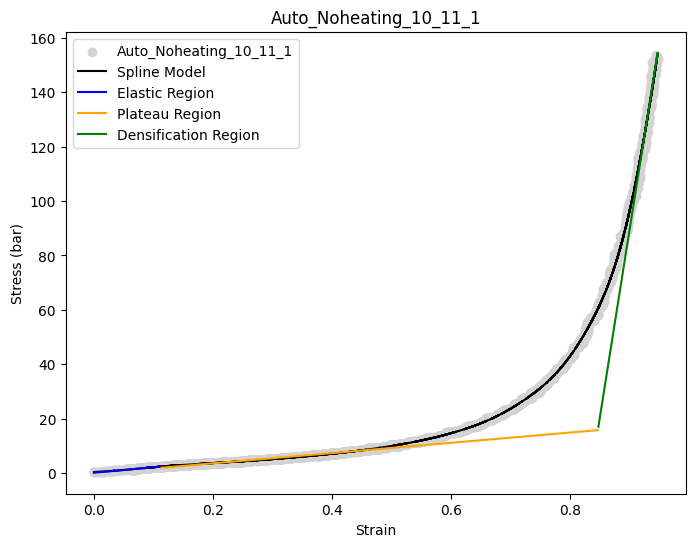

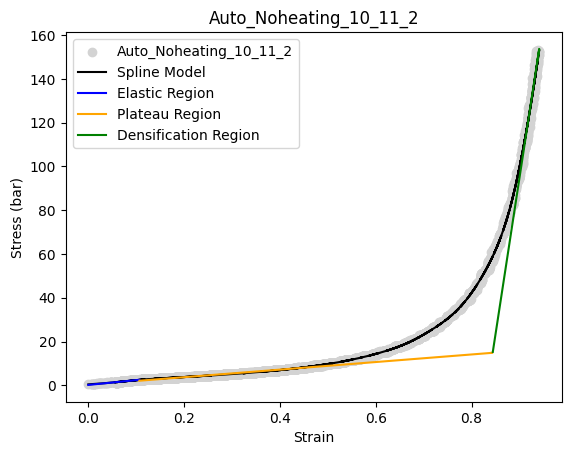

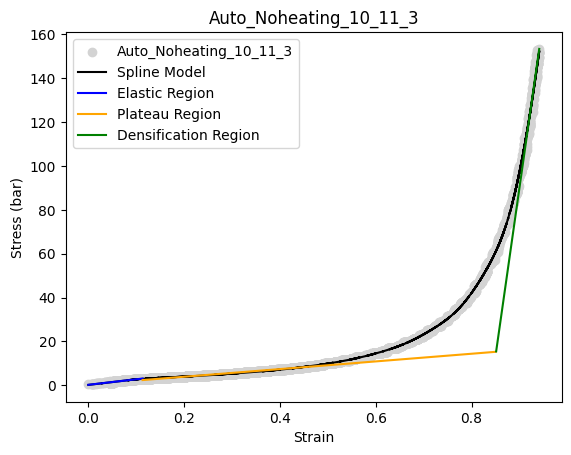

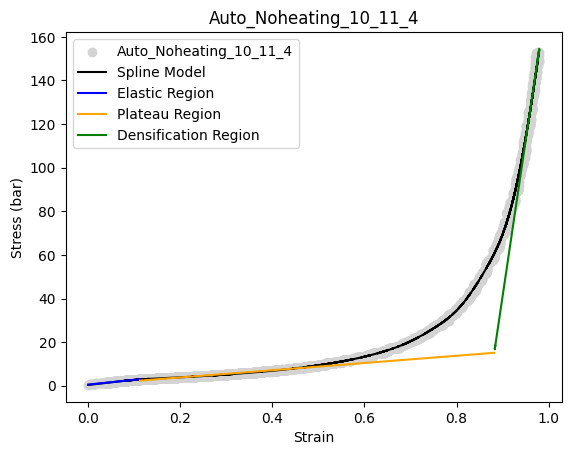

[{'Elastic Modulus': 20.160039624559975,
  'Yield Strength': array([2.46611018]),
  'Changepoint': 0.8474087399834749,
  'Slope Plateau': 18.835564987461098},
 {'Elastic Modulus': 22.01254787671758,
  'Yield Strength': array([2.52599997]),
  'Changepoint': 0.8441853490537815,
  'Slope Plateau': 17.30336520284787},
 {'Elastic Modulus': 25.198608946885003,
  'Yield Strength': array([3.10863303]),
  'Changepoint': 0.85112730942858,
  'Slope Plateau': 17.4768005051038},
 {'Elastic Modulus': 21.905809267285022,
  'Yield Strength': array([3.00264825]),
  'Changepoint': 0.8819239633681899,
  'Slope Plateau': 16.566802358044644}]

In [26]:
#TEST DATA
Auto_Noheating_10_11_1 = pd.read_csv('Data/compression 11/AutoNoHeating-10-11-1-240529_05292024_155944.csv')
Auto_Noheating_10_11_2 = pd.read_csv('Data/compression 11/AutoNoHeating-10-11-2-240529_05292024_160237.csv')
Auto_Noheating_10_11_3 = pd.read_csv('Data/compression 11/AutoNoHeating-10-11-3-240529_05292024_160529.csv')
Auto_Noheating_10_11_4 = pd.read_csv('Data/compression 11/AutoNoHeating-10-11-4-240529_05292024_160857.csv')

data_list = [Auto_Noheating_10_11_1, Auto_Noheating_10_11_2, Auto_Noheating_10_11_3, Auto_Noheating_10_11_4]
interpretData(data_list, thickness_info = False)

Thickness: [111, 108, 104, 104, 102]


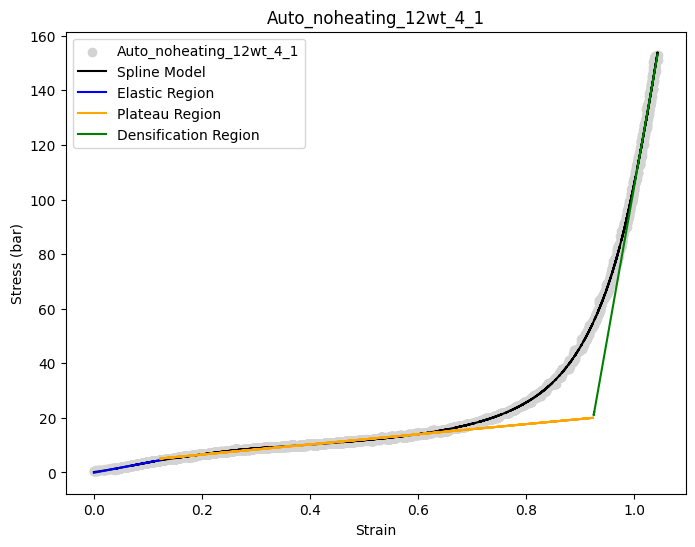

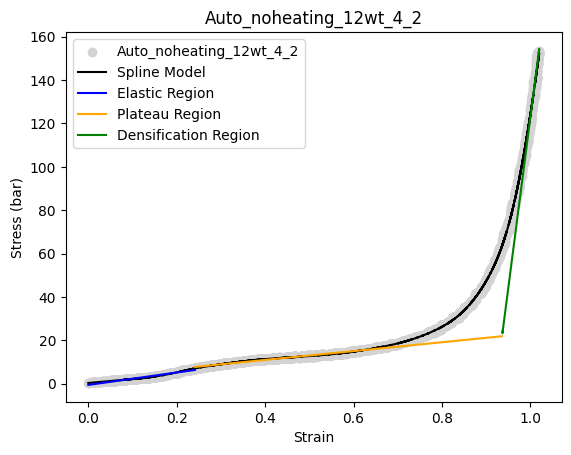

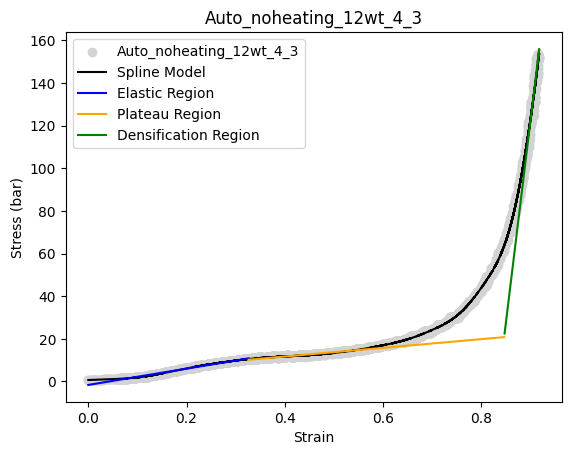

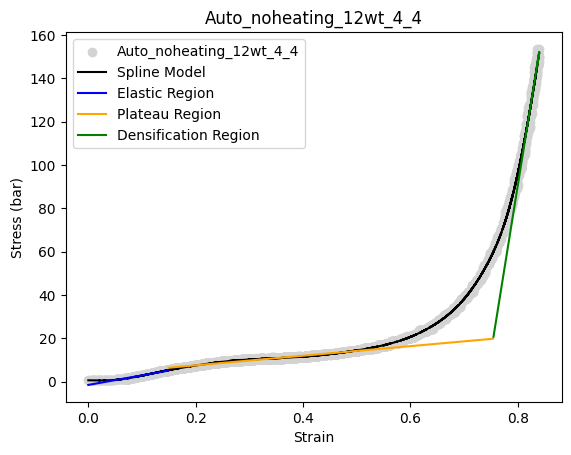

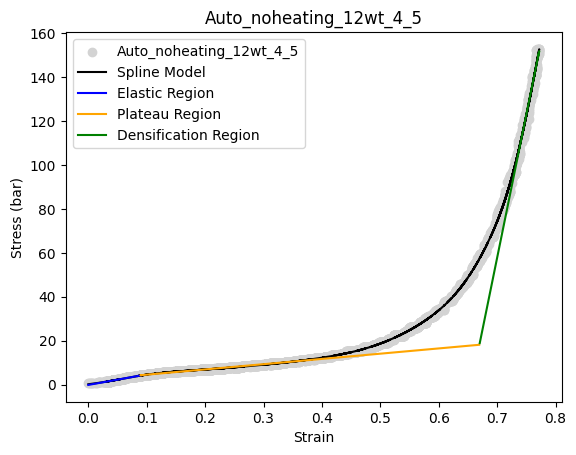

AttributeError: 'list' object has no attribute 'split'

In [29]:
#ALL DATA
#compression 4
Auto_noheating_10wt_4_1 = pd.read_csv('Data/compression 4/AutoNoheating-10-4-1-240223_02232024_161809.csv')
Auto_noheating_10wt_4_2 = pd.read_csv('Data/compression 4/AutoNoheating-10-4-2-240223_02232024_162119.csv')
Auto_noheating_10wt_4_3 = pd.read_csv('Data/compression 4/AutoNoheating-10-4-3-240223_02232024_162456.csv')

data_list_10_4 = [Auto_noheating_10wt_4_1, Auto_noheating_10wt_4_2, Auto_noheating_10wt_4_3]
thickness_10_4 = [105,105,105]
#properties_10_4 = interpretData(data_list_10_4, thickness_info = True, thickness_list = thickness_10_4)
#elasticModulus_10_4 = getElasticModulus(properties_10_4)


Auto_noheating_12wt_4_1 = pd.read_csv('Data/compression 4/AutoNoheating-12-4-1-240223_02232024_163339.csv')
Auto_noheating_12wt_4_2 = pd.read_csv('Data/compression 4/AutoNoheating-12-4-2-240223_02232024_163631.csv')
Auto_noheating_12wt_4_3 = pd.read_csv('Data/compression 4/AutoNoheating-12-4-3-240223_02232024_163935.csv')
Auto_noheating_12wt_4_4 = pd.read_csv('Data/compression 4/AutoNoheating-12-4-4-240223_02232024_164316.csv')
Auto_noheating_12wt_4_5 = pd.read_csv('Data/compression 4/AutoNoheating-12-4-5-240223_02232024_164618.csv')

data_list_12_4 = [Auto_noheating_12wt_4_1, Auto_noheating_12wt_4_2, Auto_noheating_12wt_4_3, Auto_noheating_12wt_4_4, Auto_noheating_12wt_4_5]
thickness_12_4 = [111,108,104,104,102]
properties_12_4 = interpretData(data_list_12_4, thickness_info = True, thickness_list = thickness_12_4)
elasticModulus_12_4 = getElasticModulus(properties_12_4)


Auto_noheating_15wt_4_1 = pd.read_csv('Data/compression 4 4 days/AutoNoheating-15-4-1-240226_02262024_162514.csv')
Auto_noheating_15wt_4_2 = pd.read_csv('Data/compression 4 4 days/AutoNoheating-15-4-2-240226_02262024_162808.csv')
Auto_noheating_15wt_4_3 = pd.read_csv('Data/compression 4 4 days/AutoNoheating-15-4-3-240226_02262024_163110.csv')
Auto_noheating_15wt_4_4 = pd.read_csv('Data/compression 4 4 days/AutoNoheating-15-4-4-240226_02262024_163353.csv')

data_list_15_4 = [Auto_noheating_15wt_4_1, Auto_noheating_15wt_4_2, Auto_noheating_15wt_4_3, Auto_noheating_15wt_4_4]
thickness_15_4 = [109,103,100,100]
properties_15_4 = interpretData(data_list_15_4, thickness_info = True, thickness_list = thickness_15_4)
elasticModulus_15_4 = getElasticModulus(properties_15_4)


Auto_noheating_17wt_4_1 = pd.read_csv('Data/compression 4 4 days/AutoNoheating-17-4-1-240226_02262024_163853.csv')
Auto_noheating_17wt_4_2 = pd.read_csv('Data/compression 4 4 days/AutoNoheating-17-4-2-240226_02262024_164117.csv')
Auto_noheating_17wt_4_3 = pd.read_csv('Data/compression 4 4 days/AutoNoheating-17-4-3-240226_02262024_164351.csv')
Auto_noheating_17wt_4_4 = pd.read_csv('Data/compression 4 4 days/AutoNoheating-17-4-4-240226_02262024_164621.csv')

data_list_17_4 = [Auto_noheating_17wt_4_1, Auto_noheating_17wt_4_2, Auto_noheating_17wt_4_3, Auto_noheating_17wt_4_4]
thickness_17_4 = [109,106,106,105]
properties_17_4 = interpretData(data_list_17_4, thickness_info = True, thickness_list = thickness_17_4)
elasticModulus_17_4 = getElasticModulus(properties_17_4)


#compression 5
Auto_noheating_10wt_5_1 = pd.read_csv('Data/compression 5/AutoNoheating-10-5-1-240223_02232024_193040.csv')
Auto_noheating_10wt_5_2 = pd.read_csv('Data/compression 5/AutoNoheating-10-5-2-240223_02232024_193342.csv')
Auto_noheating_10wt_5_3 = pd.read_csv('Data/compression 5/AutoNoheating-10-5-3-240223_02232024_193652.csv')
Auto_noheating_10wt_5_4 = pd.read_csv('Data/compression 5/AutoNoheating-10-5-4-240223_02232024_193947.csv')

data_list_10_5 = [Auto_noheating_10wt_5_1, Auto_noheating_10wt_5_2, Auto_noheating_10wt_5_3, Auto_noheating_10wt_5_4]
thickness_10_5 = [117,142,149,118]
properties_10_5 = interpretData(data_list_10_5, thickness_info = True, thickness_list = thickness_10_5)
elasticModulus_10_5 = getElasticModulus(properties_10_5)


Auto_noheating_17wt_5_1 = pd.read_csv('Data/compression 5/AutoNoheating-17-5-1-240223_02232024_194527.csv')
Auto_noheating_17wt_5_2 = pd.read_csv('Data/compression 5/AutoNoheating-17-5-2-240223_02232024_194752.csv')
Auto_noheating_17wt_5_3 = pd.read_csv('Data/compression 5/AutoNoheating-17-5-3-240223_02232024_195016.csv')
Auto_noheating_17wt_5_4 = pd.read_csv('Data/compression 5/AutoNoheating-17-5-4-240223_02232024_195303.csv')

data_list_17_5 = [Auto_noheating_17wt_5_1, Auto_noheating_17wt_5_2, Auto_noheating_17wt_5_3, Auto_noheating_17wt_5_4]
thickness_17_5 = [107,106,101,100]
properties_17_5 = interpretData(data_list_17_5, thickness_info = True, thickness_list = thickness_17_5)
elasticModulus_17_5 = getElasticModulus(properties_17_5)


#compression 6
Auto_noheating_10wt_6_day1_1 = pd.read_csv('Data/compression 6/AutoNoheating-10-6-day1-1-240228_02282024_201331.csv')
Auto_noheating_10wt_6_day1_2 = pd.read_csv('Data/compression 6/AutoNoheating-10-6-day1-2-240228_02282024_201646.csv')
Auto_noheating_10wt_6_day1_3 = pd.read_csv('Data/compression 6/AutoNoheating-10-6-day1-3-240228_02282024_201943.csv')
Auto_noheating_10wt_6_day1_4 = pd.read_csv('Data/compression 6/AutoNoheating-10-6-day1-4-240228_02282024_202246.csv')

data_list_10_6_day1 = [Auto_noheating_10wt_6_day1_1, Auto_noheating_10wt_6_day1_2, Auto_noheating_10wt_6_day1_3, Auto_noheating_10wt_6_day1_4]
thickness_10_6_day1 = [99, 86, 98, 120]
properties_10_6_1 = interpretData(data_list_10_6_day1, thickness_info = True, thickness_list = thickness_10_6_day1)
elasticModulus_10_6_1 = getElasticModulus(properties_10_6_1)


Auto_noheating_10wt_6_day2_1 = pd.read_csv('Data/compression 6/AutoNoheating-10-6-day2-1-240229_02292024_165802.csv')
Auto_noheating_10wt_6_day2_2 = pd.read_csv('Data/compression 6/AutoNoheating-10-6-day2-2-240229_02292024_170133.csv')
Auto_noheating_10wt_6_day2_3 = pd.read_csv('Data/compression 6/AutoNoheating-10-6-day2-3-240229_02292024_170353.csv')
Auto_noheating_10wt_6_day2_4 = pd.read_csv('Data/compression 6/AutoNoheating-10-6-day2-4-240229_02292024_170638.csv')
Auto_noheating_10wt_6_day2_5 = pd.read_csv('Data/compression 6/AutoNoheating-10-6-day2-5-240229_02292024_170950.csv')    

data_list_10_6_day2 = [Auto_noheating_10wt_6_day2_1, Auto_noheating_10wt_6_day2_2, Auto_noheating_10wt_6_day2_3, Auto_noheating_10wt_6_day2_4, Auto_noheating_10wt_6_day2_5]
thickness_10_6_day2 = [76, 76, 62, 130, 156]
properties_10_6_2 = interpretData(data_list_10_6_day2, thickness_info = True, thickness_list = thickness_10_6_day2)
elasticModulus_10_6_2 = getElasticModulus(properties_10_6_2)


Auto_noheating_10wt_6_day3_1 = pd.read_csv('Data/compression 6/AutoNoheating-10-6-day3-1-240301_03012024_155023.csv')
Auto_noheating_10wt_6_day3_2 = pd.read_csv('Data/compression 6/AutoNoheating-10-6-day3-2-240301_03012024_155302.csv')
Auto_noheating_10wt_6_day3_3 = pd.read_csv('Data/compression 6/AutoNoheating-10-6-day3-3-240301_03012024_155535.csv')
Auto_noheating_10wt_6_day3_4 = pd.read_csv('Data/compression 6/AutoNoheating-10-6-day3-4-240301_03012024_155819.csv')
Auto_noheating_10wt_6_day3_5 = pd.read_csv('Data/compression 6/AutoNoheating-10-6-day3-5-240301_03012024_160114.csv')

data_list_10_6_day3 = [Auto_noheating_10wt_6_day3_1, Auto_noheating_10wt_6_day3_2, Auto_noheating_10wt_6_day3_3, Auto_noheating_10wt_6_day3_4, Auto_noheating_10wt_6_day3_5]
thickness_10_6_day3 = [74, 76, 121, 119, 113]
properties_10_6_3 = interpretData(data_list_10_6_day3, thickness_info = True, thickness_list = thickness_10_6_day3)
elasticModulus_10_6_3 = getElasticModulus(properties_10_6_3)


#compression 7
Auto_heating_12_7_1_1 = pd.read_csv('Data/compression 7/AutoHeating-12-7-1-1-240320_03202024_202947.csv')
Auto_heating_12_7_1_2 = pd.read_csv('Data/compression 7/AutoHeating-12-7-1-2-240320_03202024_203323.csv')
Auto_heating_12_7_1_3 = pd.read_csv('Data/compression 7/AutoHeating-12-7-1-3-240320_03202024_203606.csv')
Auto_heating_12_7_1_4 = pd.read_csv('Data/compression 7/AutoHeating-12-7-1-4-240320_03202024_203910.csv')

data_list_12_7_1 = [Auto_heating_12_7_1_1, Auto_heating_12_7_1_2, Auto_heating_12_7_1_3, Auto_heating_12_7_1_4]
thickness_12_7_1 = [115, 122, 125, 125]
properties_12_7_1 = interpretData(data_list_12_7_1, thickness_info = True, thickness_list = thickness_12_7_1)
elasticModulus_12_7_1 = getElasticModulus(properties_12_7_1)


Auto_heating_12_7_2_1 = pd.read_csv('Data/compression 7/AutoHeating-12-7-2-1-240320_03202024_204415.csv')
Auto_heating_12_7_2_2 = pd.read_csv('Data/compression 7/AutoHeating-12-7-2-2-240320_03202024_204706.csv')
Auto_heating_12_7_2_3 = pd.read_csv('Data/compression 7/AutoHeating-12-7-2-3-240320_03202024_204950.csv')
Auto_heating_12_7_2_4 = pd.read_csv('Data/compression 7/AutoHeating-12-7-2-4-240320_03202024_205221.csv')

data_list_12_7_2 = [Auto_heating_12_7_2_1, Auto_heating_12_7_2_2, Auto_heating_12_7_2_3, Auto_heating_12_7_2_4]
thickness_12_7_2 = [108,112,116,115]
properties_12_7_2 = interpretData(data_list_12_7_2, thickness_info = True, thickness_list = thickness_12_7_2)
elasticModulus_12_7_2 = getElasticModulus(properties_12_7_2)


#compression 8
Auto_heating_12_8_1 = pd.read_csv('Data/compression 8/AutoHeating-12-8-1-1-240328_03282024_152144.csv')
Auto_heating_12_8_2 = pd.read_csv('Data/compression 8/AutoHeating-12-8-1-2-240328_03282024_152416.csv')
Auto_heating_12_8_3 = pd.read_csv('Data/compression 8/AutoHeating-12-8-1-3-240328_03282024_152657.csv')
Auto_heating_12_8_4 = pd.read_csv('Data/compression 8/AutoHeating-12-8-1-4-240328_03282024_152944.csv')

data_list_12_8 = [Auto_heating_12_8_1, Auto_heating_12_8_2, Auto_heating_12_8_3, Auto_heating_12_8_4]
thickness_12_8 = [100,105,110,116]
properties_12_8 = interpretData(data_list_12_8, thickness_info = True, thickness_list = thickness_12_8)
elasticModulus_12_8 = getElasticModulus(properties_12_8)


Auto_heating_17_8_1 = pd.read_csv('Data/compression 8/AutoHeating-17-8-1-1-240328_03282024_153404.csv')
Auto_heating_17_8_2 = pd.read_csv('Data/compression 8/AutoHeating-17-8-1-2-240328_03282024_153634.csv')
Auto_heating_17_8_3 = pd.read_csv('Data/compression 8/AutoHeating-17-8-1-3-240328_03282024_153853.csv')
Auto_heating_17_8_4 = pd.read_csv('Data/compression 8/AutoHeating-17-8-1-4-240328_03282024_154142.csv')

data_list_17_8 = [Auto_heating_17_8_1, Auto_heating_17_8_2, Auto_heating_17_8_3, Auto_heating_17_8_4]
thickness_17_8 = [103,104,107,109]
properties_17_8 = interpretData(data_list_17_8, thickness_info = True, thickness_list = thickness_17_8)
elasticModulus_17_8 = getElasticModulus(properties_17_8)


#compression 9
Auto_heating_13_9_1 = pd.read_csv('Data/compression 9/AutoHeating-13-9-1--240404_04042024_173756.csv')
Auto_heating_13_9_2 = pd.read_csv('Data/compression 9/AutoHeating-13-9-2--240404_04042024_174116.csv')
Auto_heating_13_9_3 = pd.read_csv('Data/compression 9/AutoHeating-13-9-3--240404_04042024_174359.csv')  
Auto_heating_13_9_4 = pd.read_csv('Data/compression 9/AutoHeating-13-9-4--240404_04042024_174655.csv')

data_list_13_9 = [Auto_heating_13_9_1, Auto_heating_13_9_2, Auto_heating_13_9_3, Auto_heating_13_9_4]
thickness_13_9 = [112,121,125,137]
properties_13_9 = interpretData(data_list_13_9, thickness_info = True, thickness_list = thickness_13_9)
elasticModulus_13_9 = getElasticModulus(properties_12_8)


#compression 10
Auto_heating_17_10_1 = pd.read_csv('Data/compression 10/AutoHeating-17-10-1-240424_04242024_224404.csv')
Auto_heating_17_10_2 = pd.read_csv('Data/compression 10/AutoHeating-17-10-2-240424_04242024_224654.csv')
Auto_heating_17_10_3 = pd.read_csv('Data/compression 10/AutoHeating-17-10-3-240424_04242024_224921.csv')
Auto_heating_17_10_4 = pd.read_csv('Data/compression 10/AutoHeating-17-10-4-240424_04242024_225129.csv')
Auto_heating_17_10_5 = pd.read_csv('Data/compression 10/AutoHeating-17-10-5-240424_04242024_232454.csv')
Auto_heating_17_10_6 = pd.read_csv('Data/compression 10/AutoHeating-17-10-6-240424_04242024_232735.csv')
Auto_heating_17_10_7 = pd.read_csv('Data/compression 10/AutoHeating-17-10-7-240424_04242024_232950.csv')

data_list_17_10 = [Auto_heating_17_10_1, Auto_heating_17_10_2, Auto_heating_17_10_3, Auto_heating_17_10_4,
                   Auto_heating_17_10_5, Auto_heating_17_10_6, Auto_heating_17_10_7]
properties_17_10 = interpretData(data_list_17_10, thickness_info = False)
elasticModulus_17_10 = getElasticModulus(properties_17_10)


#compression 11
Auto_heating_10_11_1 = pd.read_csv('Data/compression 11/AutoNoHeating-10-11-1-240529_05292024_155944.csv')
Auto_heating_10_11_2 = pd.read_csv('Data/compression 11/AutoNoHeating-10-11-2-240529_05292024_160237.csv')
Auto_heating_10_11_3 = pd.read_csv('Data/compression 11/AutoNoHeating-10-11-3-240529_05292024_160529.csv')
Auto_heating_10_11_4 = pd.read_csv('Data/compression 11/AutoNoHeating-10-11-4-240529_05292024_160857.csv')

data_list_10_11 = [Auto_heating_10_11_1, Auto_heating_10_11_2, Auto_heating_10_11_3, Auto_heating_10_11_4]
properties_10_11 = interpretData(data_list_10_11, thickness_info = False)
elasticModulus_10_11 = getElasticModulus(properties_10_11)


Auto_heating_12_11_1 = pd.read_csv('Data/compression 11/AutoNoHeating-12-11-1-240530_05302024_161031.csv')
Auto_heating_12_11_2 = pd.read_csv('Data/compression 11/AutoNoHeating-12-11-2-240530_05302024_161322.csv')
Auto_heating_12_11_3 = pd.read_csv('Data/compression 11/AutoNoHeating-12-11-3-240530_05302024_161603.csv')
Auto_heating_12_11_4 = pd.read_csv('Data/compression 11/AutoNoHeating-12-11-4-240530_05302024_161848.csv')

data_list_12_11 = [Auto_heating_12_11_1, Auto_heating_12_11_2, Auto_heating_12_11_3, Auto_heating_12_11_4]
properties_12_11 = interpretData(data_list_12_11, thickness_info = False)
elasticModulus_12_11 = getElasticModulus(properties_12_11)


Auto_heating_14_11_1 = pd.read_csv('Data/compression 11/AutoNoHeating-14-11-1-240530_05302024_163014.csv')
Auto_heating_12_11_2 = pd.read_csv('Data/compression 11/AutoNoHeating-14-11-2-240530_05302024_163256.csv')
Auto_heating_12_11_3 = pd.read_csv('Data/compression 11/AutoNoHeating-14-11-3-240530_05302024_163547.csv')
Auto_heating_12_11_4 = pd.read_csv('Data/compression 11/AutoNoHeating-14-11-4-240530_05302024_163822.csv')

data_list_14_11 = [Auto_heating_14_11_1, Auto_heating_14_11_2, Auto_heating_14_11_3, Auto_heating_14_11_4]
properties_14_11 = interpretData(data_list_14_11, thickness_info = False)
elasticModulus_14_11 = getElasticModulus(properties_14_11)


Auto_heating_16_11_1 = pd.read_csv('Data/compression 11/AutoNoHeating-16-11-1-240530_05302024_172602.csv')
Auto_heating_16_11_2 = pd.read_csv('Data/compression 11/AutoNoHeating-16-11-2-240530_05302024_172818.csv')
Auto_heating_16_11_3 = pd.read_csv('Data/compression 11/AutoNoHeating-16-11-3-240530_05302024_173048.csv')
Auto_heating_16_11_4 = pd.read_csv('Data/compression 11/AutoNoHeating-16-11-4-240530_05302024_173310.csv')

data_list_16_11 = [Auto_heating_16_11_1, Auto_heating_16_11_2, Auto_heating_16_11_3, Auto_heating_16_11_4]
properties_16_11 = interpretData(data_list_16_11, thickness_info = False)
elasticModulus_16_11 = getElasticModulus(properties_16_11)

plt.title("1st Slope (Modulus) vs. Polymer Concentration")
plt.xlabel("Polymer Concentration (wt%)")
plt.ylabel("1st Slope (bar)")
plt.show()